In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [ ]:
# Set seed for reproducibility
np.random.seed(123)

# DATA LOADING

In [ ]:
df=pd.read_csv("/content/Real estate valuation data set.csv")

In [ ]:
df

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1
...,...,...,...,...,...,...,...,...
409,410,2013.000,13.7,4082.01500,0,24.94155,121.50381,15.4
410,411,2012.667,5.6,90.45606,9,24.97433,121.54310,50.0
411,412,2013.250,18.8,390.96960,7,24.97923,121.53986,40.6
412,413,2013.000,8.1,104.81010,5,24.96674,121.54067,52.5


In [ ]:
X=df['X3 distance to the nearest MRT station']
y=df['Y house price of unit area']

In [ ]:
print("shape of X :",X.shape)
print("shape of y :",y.shape)

shape of X : (414,)
shape of y : (414,)


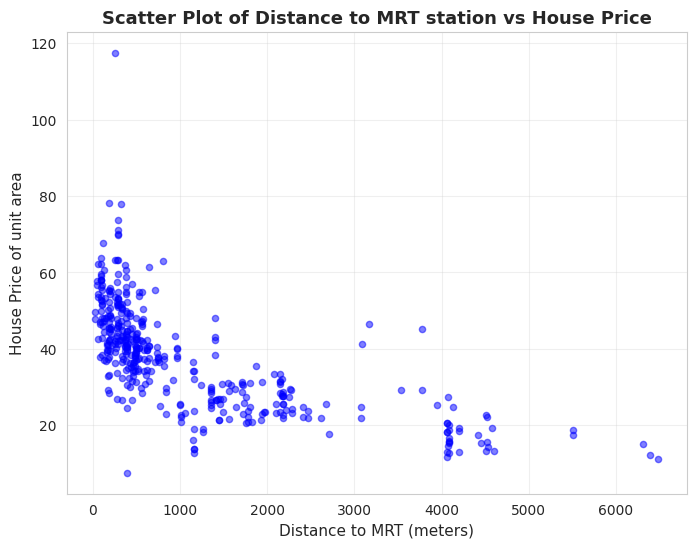

In [ ]:
#SCATTERPLOT OF X VS Y
plt.figure(figsize=(8, 6))
plt.scatter(X, y, alpha=0.5, color='blue', s=20)   # scatter style
plt.xlabel('Distance to MRT (meters)', fontsize=11)
plt.ylabel('House Price of unit area', fontsize=11)
plt.title('Scatter Plot of Distance to MRT station vs House Price', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Select only X and Y
df = df[['X3 distance to the nearest MRT station', 'Y house price of unit area']].copy()
df.columns = ['distance_mrt', 'price']  # Renaming for simplicity

# DATA CLEANING

In [ ]:
#MISSING VALUE HANDLING
print(f"Missing values in distance_mrt: {df['distance_mrt'].isna().sum()}")
print(f"Missing values in price: {df['price'].isna().sum()}")

# Remove missing values

df = df.dropna()

print(f" After removing missing values: {len(df)} observations")

Missing values in distance_mrt: 0
Missing values in price: 0
 After removing missing values: 414 observations


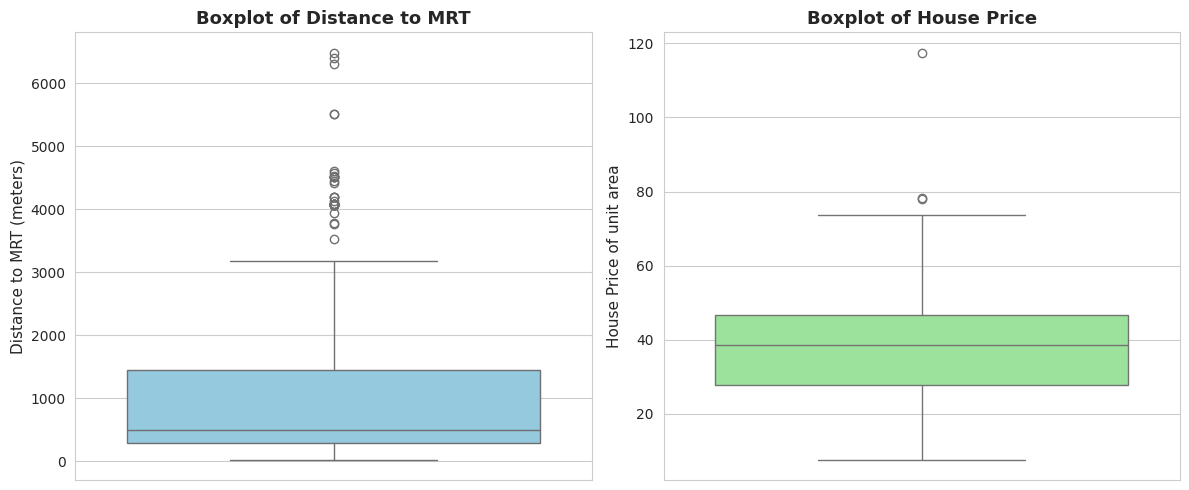

In [ ]:
#OUTLIERS HANDLING
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(y=df['distance_mrt'], color='skyblue')
plt.title('Boxplot of Distance to MRT', fontsize=13, fontweight='bold')
plt.ylabel('Distance to MRT (meters)', fontsize=11)

plt.subplot(1, 2, 2)
sns.boxplot(y=df['price'], color='lightgreen')
plt.title('Boxplot of House Price', fontsize=13, fontweight='bold')
plt.ylabel('House Price of unit area', fontsize=11)

plt.tight_layout()
plt.show()

In [ ]:
# Calculate IQR for distance_mrt
Q1_x = df['distance_mrt'].quantile(0.25)
Q3_x = df['distance_mrt'].quantile(0.75)
IQR_x = Q3_x - Q1_x
lower_x = Q1_x - 1.5 * IQR_x
upper_x = Q3_x + 1.5 * IQR_x

# Calculate IQR for price
Q1_y = df['price'].quantile(0.25)
Q3_y = df['price'].quantile(0.75)
IQR_y = Q3_y - Q1_y
lower_y = Q1_y - 1.5 * IQR_y
upper_y = Q3_y + 1.5 * IQR_y

# Count outliers
outliers_x = ((df['distance_mrt'] < lower_x) | (df['distance_mrt'] > upper_x)).sum()
outliers_y = ((df['price'] < lower_y) | (df['price'] > upper_y)).sum()

print(f"Outliers in distance_mrt: {outliers_x}")
print(f"Outliers in price: {outliers_y}")


df_before_outlier = df.copy()

# Remove outliers
df = df[(df['distance_mrt'] >= lower_x) & (df['distance_mrt'] <= upper_x) &
        (df['price'] >= lower_y) & (df['price'] <= upper_y)]

print(f" After removing outliers: {len(df)} observations")

Outliers in distance_mrt: 37
Outliers in price: 3
 After removing outliers: 374 observations


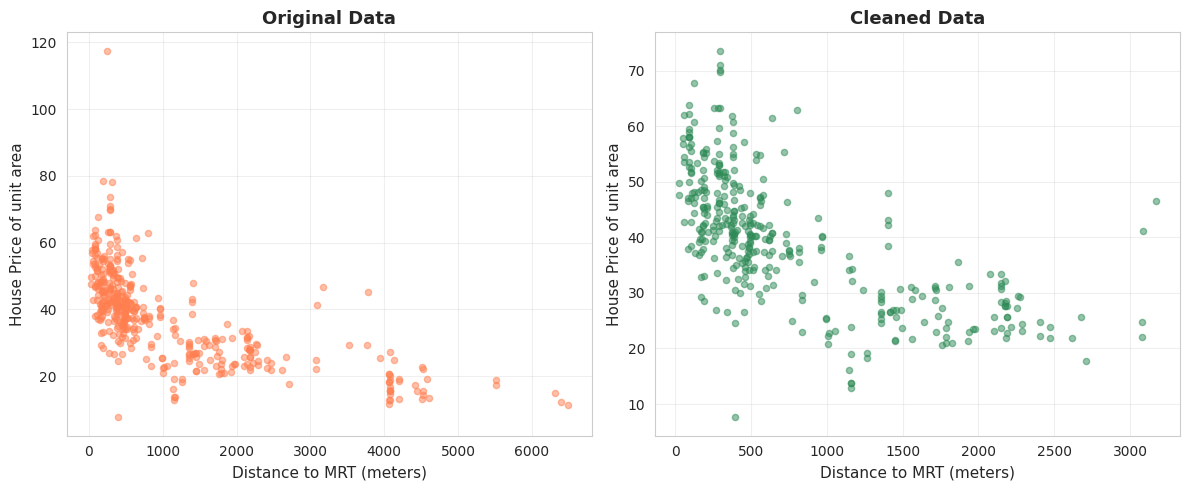

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(df_before_outlier['distance_mrt'], df_before_outlier['price'],
                alpha=0.5, color='coral', s=20)
axes[0].set_xlabel('Distance to MRT (meters)', fontsize=11)
axes[0].set_ylabel('House Price of unit area', fontsize=11)
axes[0].set_title('Original Data', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].scatter(df['distance_mrt'], df['price'],
                alpha=0.5, color='seagreen', s=20)
axes[1].set_xlabel('Distance to MRT (meters)', fontsize=11)
axes[1].set_ylabel('House Price of unit area', fontsize=11)
axes[1].set_title('Cleaned Data', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Model Building and Cross-Validation

In [ ]:
#TRAIN-TEST SPLIT
X = df['distance_mrt'].values
y = df['price'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123
)

print(f"Training set: {len(X_train)} observations")
print(f"Test set: {len(X_test)} observations")

Training set: 299 observations
Test set: 75 observations


BIN SMOOTHER

In [ ]:
class StepFunction:
    def __init__(self, x, y):

        if len(y) != len(x) - 1:
            raise ValueError("Length of y must be one less than length of x")
        self.x = x
        self.y = y

    def predict(self, z):
        # Predict step function value at z (scalar or array).
        z = np.asarray(z)
        result = np.zeros_like(z, dtype=float)
        for i in range(len(self.y)):
            result[(z >= self.x[i]) & (z < self.x[i + 1])] = self.y[i]
        return result

In [ ]:
def bin_smoother_predict(X_train, y_train, X_test, k):

    # Bin edges based on training data range
    BI = np.linspace(X_train.min(), X_train.max(), k + 1)
    Means = []

    for j in range(k):
        indices = np.where((X_train > BI[j]) & (X_train <= BI[j+1]))[0]
        m = np.mean(y_train[indices]) if len(indices) > 0 else np.mean(y_train)
        Means.append(m)

    sf = StepFunction(BI, Means)

    # Predict on test data
    predictions = sf.predict(X_test)

    return predictions

KERNEL SMOOTHER

In [ ]:
def gaussian(x):
    return np.exp(-(x**2)/2)
def kernel_reg(x, X_train, y_train, h, kernel = gaussian ):
    m = len(x)
    res = []
    for k in range(m):
        wt = kernel((x[k] - X_train)/h) # computing weights
        res.append(sum(wt*y_train)/sum(wt)) # computing kernel smoother regression estimate
    return np.array(res)

CROSS VALIDATION

In [ ]:
bin_params = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
kernel_params = [4,5,10,50,100,200,300]
knn_params = [3, 5, 7, 9, 11, 15, 20, 25, 30, 35, 40, 45, 50]

In [ ]:
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=123)

print(f"Using {n_folds}-fold cross-validation")
print(f"Each fold will have ~{len(X_train)//n_folds} validation samples")

Using 5-fold cross-validation
Each fold will have ~59 validation samples


In [ ]:
bin_results = []

for k in bin_params:
    fold_mse = []
    fold_mae = []

    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        X_fold_train = X_train[train_idx]
        y_fold_train = y_train[train_idx]
        X_fold_val = X_train[val_idx]
        y_fold_val = y_train[val_idx]

        # Use your custom bin smoother
        y_pred_val = bin_smoother_predict(X_fold_train, y_fold_train, X_fold_val, k)

        fold_mse.append(mean_squared_error(y_fold_val, y_pred_val))
        fold_mae.append(mean_absolute_error(y_fold_val, y_pred_val))

    bin_results.append({
        'n_bins': k,
        'avg mse': np.mean(fold_mse),
        'avg mae': np.mean(fold_mae),

    })

bin_cv_df = pd.DataFrame(bin_results)
best_bin = int(bin_cv_df.loc[bin_cv_df['avg mse'].idxmin(), 'n_bins'])

In [ ]:
bin_cv_df

,n_bins,avg mse,avg mae
0,5,75.680214,6.558810
1,10,65.473446,5.913366
2,15,70.906100,6.285966
3,20,70.687554,6.247277
4,25,71.621186,6.368728
5,30,75.057048,6.490288
6,35,72.655324,6.302046
7,40,77.442583,6.513308
8,45,77.075862,6.471938
9,50,73.842252,6.407238


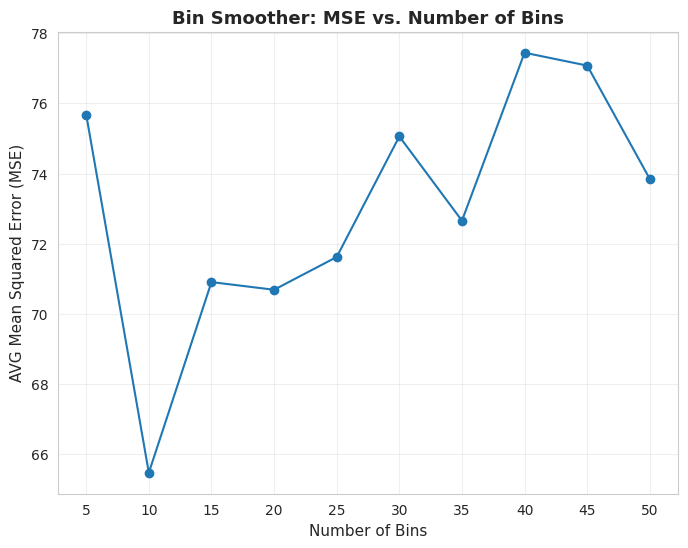

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(bin_cv_df['n_bins'], bin_cv_df['avg mse'], marker='o')
plt.xlabel('Number of Bins', fontsize=11)
plt.ylabel('AVG Mean Squared Error (MSE)', fontsize=11)
plt.title('Bin Smoother: MSE vs. Number of Bins', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(bin_cv_df['n_bins'])
plt.show()

In [ ]:
print(f" Best number of bins: {best_bin}")
print(f"  Validation MSE: {bin_cv_df['avg mse'].min():.4f}")
print(f"  Validation MAE: {bin_cv_df.loc[bin_cv_df['avg mse'].idxmin(), 'avg mae']:.4f}")

 Best number of bins: 10
  Validation MSE: 65.4734
  Validation MAE: 5.9134


In [ ]:
kernel_results = []

for h in kernel_params:
    fold_mse = []
    fold_mae = []

    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        X_fold_train = X_train[train_idx]
        y_fold_train = y_train[train_idx]
        X_fold_val = X_train[val_idx]
        y_fold_val = y_train[val_idx]

        # Use your custom kernel regression
        y_pred_val = kernel_reg(X_fold_val, X_fold_train, y_fold_train, h, kernel=gaussian)

        fold_mse.append(mean_squared_error(y_fold_val, y_pred_val))
        fold_mae.append(mean_absolute_error(y_fold_val, y_pred_val))

    kernel_results.append({
        'bandwidth': h,
        'avg mse': np.mean(fold_mse),
        'avg mae': np.mean(fold_mae),

    })

kernel_cv_df = pd.DataFrame(kernel_results)
best_kernel = kernel_cv_df.loc[kernel_cv_df['avg mse'].idxmin(), 'bandwidth']

In [ ]:
kernel_cv_df

,bandwidth,avg mse,avg mae
0,4,56.934461,5.606698
1,5,56.837792,5.639777
2,10,56.925369,5.749313
3,50,58.602158,5.883077
4,100,60.190298,5.946422
5,200,61.360226,6.033101
6,300,63.490182,6.169407


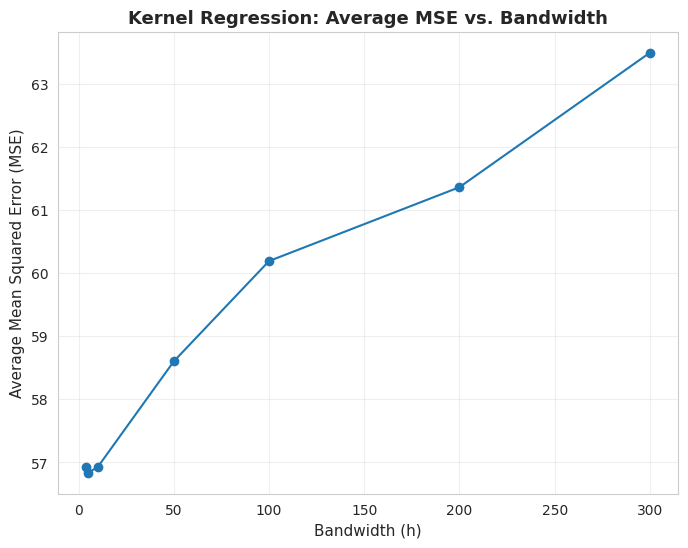

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(kernel_cv_df['bandwidth'], kernel_cv_df['avg mse'], marker='o')
plt.xlabel('Bandwidth (h)', fontsize=11)
plt.ylabel('Average Mean Squared Error (MSE)', fontsize=11)
plt.title('Kernel Regression: Average MSE vs. Bandwidth', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
best_kernel = kernel_cv_df.loc[kernel_cv_df['avg mse'].idxmin(), 'bandwidth']

print(f" Best bandwidth: {best_kernel}")
print(f"  Validation MSE: {kernel_cv_df['avg mse'].min():.4f}")
print(f"  Validation MAE: {kernel_cv_df.loc[kernel_cv_df['avg mse'].idxmin(), 'avg mae']:.4f}")

 Best bandwidth: 5
  Validation MSE: 56.8378
  Validation MAE: 5.6398


In [ ]:
knn_results = []

for k in knn_params:
    fold_mse = []
    fold_mae = []

    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        X_fold_train = X_train[train_idx].reshape(-1, 1)  # Reshape to 2D
        y_fold_train = y_train[train_idx]
        X_fold_val = X_train[val_idx].reshape(-1, 1)      # Reshape to 2D
        y_fold_val = y_train[val_idx]

        # Use sklearn's KNeighborsRegressor
        knn_model = KNeighborsRegressor(n_neighbors=k, weights='uniform')
        knn_model.fit(X_fold_train, y_fold_train)

        y_pred_val = knn_model.predict(X_fold_val)

        fold_mse.append(mean_squared_error(y_fold_val, y_pred_val))
        fold_mae.append(mean_absolute_error(y_fold_val, y_pred_val))

    knn_results.append({
        'k': k,
        'avg mse': np.mean(fold_mse),
        'avg mae': np.mean(fold_mae),

    })

knn_cv_df = pd.DataFrame(knn_results)

In [ ]:
knn_cv_df

,k,avg mse,avg mae
0,3,60.680987,5.948405
1,5,58.747206,5.770807
2,7,57.704618,5.670592
3,9,56.174516,5.756689
4,11,55.474253,5.711482
5,15,57.086490,5.831507
6,20,56.541047,5.805843
7,25,57.825865,5.842624
8,30,57.690278,5.817568
9,35,58.878736,5.852022


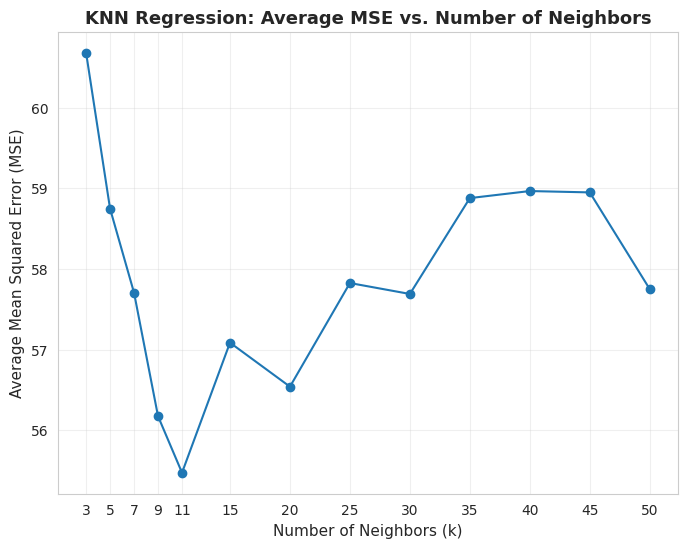

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(knn_cv_df['k'], knn_cv_df['avg mse'], marker='o')
plt.xlabel('Number of Neighbors (k)', fontsize=11)
plt.ylabel('Average Mean Squared Error (MSE)', fontsize=11)
plt.title('KNN Regression: Average MSE vs. Number of Neighbors', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(knn_cv_df['k'])
plt.show()

In [ ]:
best_knn = int(knn_cv_df.loc[knn_cv_df['avg mse'].idxmin(), 'k'])
print(f" Best k: {best_knn}")
print(f"  Validation MSE: {knn_cv_df['avg mse'].min():.4f}")
print(f"  Validation MAE: {knn_cv_df.loc[knn_cv_df['avg mse'].idxmin(), 'avg mae']:.4f}")


 Best k: 11
  Validation MSE: 55.4743
  Validation MAE: 5.7115


# •	Model Comparison

In [ ]:
# Bin Smoother predictions
y_pred_bin = bin_smoother_predict(X_train, y_train, X_test, best_bin)
test_mse_bin = mean_squared_error(y_test, y_pred_bin)
test_mae_bin = mean_absolute_error(y_test, y_pred_bin)

# Gaussian Kernel predictions
y_pred_kernel = kernel_reg(X_test, X_train, y_train, best_kernel, kernel=gaussian)
test_mse_kernel = mean_squared_error(y_test, y_pred_kernel)
test_mae_kernel = mean_absolute_error(y_test, y_pred_kernel)

# KNN predictions
knn_final = KNeighborsRegressor(n_neighbors=best_knn, weights='uniform')
knn_final.fit(X_train.reshape(-1, 1), y_train)  # Reshape X_train
y_pred_knn = knn_final.predict(X_test.reshape(-1, 1)) # Reshape X_test
test_mse_knn = mean_squared_error(y_test, y_pred_knn)
test_mae_knn = mean_absolute_error(y_test, y_pred_knn)

In [ ]:
comparison_df = pd.DataFrame({
    'Method': ['Bin Smoother', 'Gaussian Kernel', 'KNN Smoother'],
    'Best_Parameter': [best_bin, best_kernel, best_knn],
    'Validation_MSE': [
        bin_cv_df['avg mse'].min(),
        kernel_cv_df['avg mse'].min(),
        knn_cv_df['avg mse'].min()
    ],
    'Validation_MAE': [
        bin_cv_df.loc[bin_cv_df['avg mse'].idxmin(), 'avg mae'],
        kernel_cv_df.loc[kernel_cv_df['avg mse'].idxmin(), 'avg mae'],
        knn_cv_df.loc[knn_cv_df['avg mse'].idxmin(), 'avg mae']
    ],
    'Test_MSE': [test_mse_bin, test_mse_kernel, test_mse_knn],
    'Test_MAE': [test_mae_bin, test_mae_kernel, test_mae_knn]
})

In [ ]:
comparison_df

,Method,Best_Parameter,Validation_MSE,Validation_MAE,Test_MSE,Test_MAE
0,Bin Smoother,10,65.473446,5.913366,87.055032,6.827762
1,Gaussian Kernel,5,56.837792,5.639777,81.275621,6.507858
2,KNN Smoother,11,55.474253,5.711482,84.564748,7.073818


In [ ]:
best_idx = comparison_df['Test_MSE'].idxmin()
best_method = comparison_df.loc[best_idx, 'Method']

print(f"\n BEST MODEL: {best_method}")
print(f"   Best Parameter: {comparison_df.loc[best_idx, 'Best_Parameter']}")
print(f"   Test MSE: {comparison_df.loc[best_idx, 'Test_MSE']:.4f}")
print(f"   Test MAE: {comparison_df.loc[best_idx, 'Test_MAE']:.4f}")



 BEST MODEL: Gaussian Kernel
   Best Parameter: 5
   Test MSE: 81.2756
   Test MAE: 6.5079


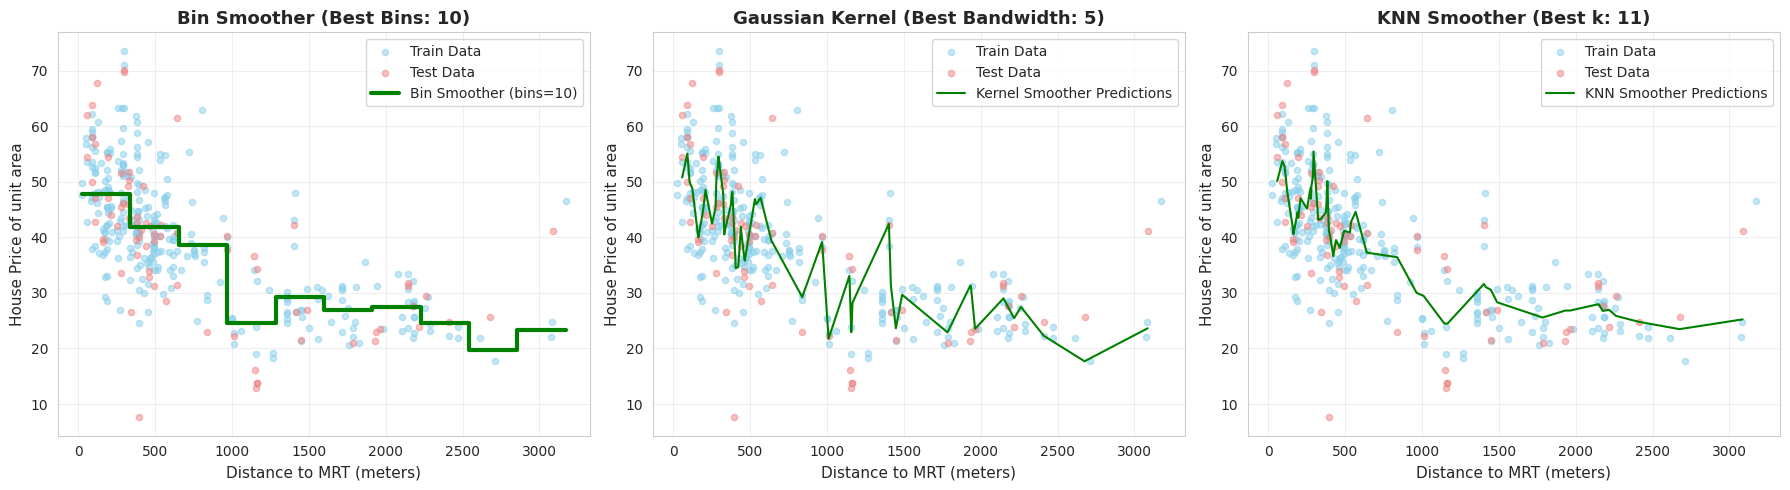

In [ ]:
plt.figure(figsize=(18, 5))

# Bin Smoother Plot
Xtr = X_train.ravel()


bins = np.linspace(Xtr.min(), Xtr.max(), best_bin + 1)


bin_index = np.digitize(Xtr, bins) - 1


bin_means = []
for b in range(best_bin):
    values_in_bin = y_train[bin_index == b]
    if len(values_in_bin) > 0:
        bin_means.append(values_in_bin.mean())
    else:
        bin_means.append(y_train.mean())
bin_means = np.array(bin_means)


step_x = np.repeat(bins, 2)[1:-1]
step_y = np.repeat(bin_means, 2)


plt.subplot(1,3,1)
#Bin Smoother Plot
plt.scatter(X_train, y_train, alpha=0.5, label='Train Data', color='skyblue', s=20)
plt.scatter(X_test, y_test, alpha=0.5, label='Test Data', color='lightcoral', s=20)

plt.step(step_x, step_y, where='mid', color='green', linewidth=3,
         label=f'Bin Smoother (bins={best_bin})')

plt.xlabel('Distance to MRT (meters)', fontsize=11)
plt.ylabel('House Price of unit area', fontsize=11)
plt.title(f'Bin Smoother (Best Bins: {best_bin})', fontsize=13, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Kernel Smoother Plot
plt.subplot(1, 3, 2)
plt.scatter(X_train, y_train, alpha=0.5, label='Train Data', color='skyblue', s=20)
plt.scatter(X_test, y_test, alpha=0.5, label='Test Data', color='lightcoral', s=20)

X_test_sorted = np.sort(X_test)
y_pred_kernel_sorted = kernel_reg(X_test_sorted, X_train, y_train, best_kernel, kernel=gaussian)
plt.plot(X_test_sorted, y_pred_kernel_sorted, color='green', label='Kernel Smoother Predictions')
plt.xlabel('Distance to MRT (meters)', fontsize=11)
plt.ylabel('House Price of unit area', fontsize=11)
plt.title(f'Gaussian Kernel (Best Bandwidth: {best_kernel})', fontsize=13, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# KNN Smoother Plot
plt.subplot(1, 3, 3)
plt.scatter(X_train, y_train, alpha=0.5, label='Train Data', color='skyblue', s=20)
plt.scatter(X_test, y_test, alpha=0.5, label='Test Data', color='lightcoral', s=20)
knn_final = KNeighborsRegressor(n_neighbors=best_knn, weights='uniform')
knn_final.fit(X_train.reshape(-1, 1), y_train)
y_pred_knn_sorted = knn_final.predict(X_test_sorted.reshape(-1, 1))
plt.plot(X_test_sorted, y_pred_knn_sorted, color='green', label=f'KNN Smoother Predictions')
plt.xlabel('Distance to MRT (meters)', fontsize=11)
plt.ylabel('House Price of unit area', fontsize=11)
plt.title(f'KNN Smoother (Best k: {best_knn})', fontsize=13, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)


plt.tight_layout()
plt.show()